# Liver Model Construction: Notebook

This notebook was to try to make the perfect gluconeogenesis pathway to see if minspan algorithm would pick it up.
Things learnt from this was:
1) If ALL the irreversible reactions were removed (HEX1, PYK and PFK), then it picked it up perfectly

2) If HEX1 and PFK were added, still perfect

3) If PYK was added, it would revert back to glycolysis minspan

Thoughts from this were:
1) since minspan minimizes the number of non zeros, since gluconeogenesis uses additional recations for the bypass, it would be more non zero values than glycolysis

2) from the extreme pathways paper, it would seem that the gluconeogenesis path  was formed from a combination of the glycolysis paths formed (loops and exchanges)


In [1]:
import os
import re
import warnings
from cobra.io import *
from cobra.io.json import *
from cobra.io.json import load_json_model as load_json_cobra_model
import escher
import mass
import numpy as np
import pandas as pd
import equilibrator_api
from equilibrator_api import ComponentContribution, Q_
import sympy as sym
from cobra import Model, Reaction, Metabolite, DictList
import cobra.test
from os.path import join
from mass.util import qcqa,qcqa_model
from mass import (
    MassConfiguration, MassMetabolite, MassModel,
    MassReaction, Simulation, UnitDefinition)
from mass.io.json import save_json_model as save_json_mass_model
from mass.visualization import plot_comparison, plot_time_profile, plot_ensemble_phase_portrait, plot_ensemble_time_profile
mass_config = MassConfiguration()
mass_config.irreversible_Keq = float("inf")
print("MASSpy version: {0}".format(mass.__version__))
from six import iteritems
import matplotlib.pyplot as plt
from mass.thermo import (
    ConcSolver, sample_concentrations,
    update_model_with_concentration_solution)
import cobra_dict as c_d
import csv
import altair as alt
from minspan.minspan import minspan,nnz
# from minspan import minspan,nnz

MASSpy version: 0.1.6


In [2]:
import sys
# from minspan import minspan,nnz
print(sys.version)

3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]


In [3]:
maps_dir = os.path.abspath("maps")
data_dir = os.path.abspath("data")
dir = os.path.abspath("")
model_dir = os.path.abspath("models")
minspan_dir= os.path.abspath("minspans_csv")

In [4]:
gly_gluco_json = os.path.join(model_dir,"glycolysis_gluconeogenesis.json")
# json.save_json_model(model=trial, filename=gly_gluco_json)

In [5]:
trial=load_json_cobra_model(filename=gly_gluco_json)

Set parameter Username
Academic license - for non-commercial use only - expires 2022-03-01


In [94]:
# Initiate empty model
gluco = cobra.Model()

In [95]:
# add a lumped reaction to account for pyr--> pep because PYK causes no gluco minspan
reactions_from_cobra=[
    'HEX1',
 'PGI',
 'FBP',
 'PFK',
 'FBA',
 'TPI',
 'GAPD',
 'PGK',
 'PGM',
 'ENO',
 'PEPCKm',
 'PYK',
 'PCm',
 'LDH_L',
 'PYRt2m',
 'ADK1',
 'ATPM',
 'NADHM',
 'PEPtm',
#  'EX_glc__D_c',
 'G6PP']
for reaction in trial.reactions:
    if reaction.id in reactions_from_cobra:
        rxn=reaction
        gluco.add_reaction(rxn)
        print(rxn)


            


HEX1: atp_c + glc__D_c --> adp_c + g6p_c + h_c
PGI: g6p_c <=> f6p_c
FBP: fdp_c + h2o_c --> f6p_c + pi_c
PFK: atp_c + f6p_c --> adp_c + fdp_c + h_c
FBA: fdp_c <=> dhap_c + g3p_c
TPI: dhap_c <=> g3p_c
GAPD: g3p_c + nad_c + pi_c <=> 13dpg_c + h_c + nadh_c
PGK: 3pg_c + atp_c <=> 13dpg_c + adp_c
PGM: 2pg_c <=> 3pg_c
ENO: 2pg_c <=> h2o_c + pep_c
PEPCKm: gtp_m + oaa_m --> co2_m + gdp_m + pep_m
PYK: adp_c + h_c + pep_c --> atp_c + pyr_c
PCm: atp_m + hco3_m + pyr_m --> adp_m + h_m + oaa_m + pi_m
LDH_L: lac__L_c + nad_c <=> h_c + nadh_c + pyr_c
PYRt2m: h_c + pyr_c --> h_m + pyr_m
ADK1: amp_c + atp_c <=> 2.0 adp_c
ATPM: atp_c + h2o_c --> adp_c + h_c + pi_c
NADHM: nadh_c --> h_c + nad_c
PEPtm: pep_m + pi_c --> pep_c + pi_m
G6PP: g6p_c + h2o_c --> glc__D_c + pi_c


In [96]:
for met in ['glc__D_c',  'h2o_c', 'h_c', 'pi_c','lac__L_c','amp_c','atp_c','adp_c',
# 'o2_c'
'atp_m','hco3_m', 'gtp_m',
# 'co2_c'
    'h_m', 'pi_m', 'adp_m', 'gdp_m', 'co2_m' ]:
    rxn = cobra.Reaction('EX_%s' % met)
    gluco.add_reaction(rxn)
    rxn.add_metabolites({met: -1})
    if met == 'glc__D_c':
        rxn.lower_bound = -1 # by convention negative exchange flux = uptake
    elif met == 'lac__L_c':
        rxn.lower_bound = -1000
    else:
        rxn.lower_bound = -1000

In [97]:
#View all the reactions that we need build
escher_builder = escher.Builder(
    model=gluco,
    map_json=os.path.join(
        maps_dir,"Gluconeogenesis.json"),highlight_missing=True)

escher_builder

Builder(highlight_missing=True)

In [98]:
gluco.reactions.EX_glc__D_c.lower_bound=-1000

In [99]:
gluco.objective = 'EX_glc__D_c'
flux_solution = gluco.optimize()
flux_solution

,fluxes,reduced_costs
HEX1,0.0,-0.5
PGI,-250.0,-0.0
FBP,250.0,0.0
PFK,0.0,-0.5
FBA,-250.0,-0.0
...,...,...
EX_h_m,1000.0,0.0
EX_pi_m,1000.0,-0.0
EX_adp_m,500.0,0.0
EX_gdp_m,500.0,0.0


In [100]:
gluco

Name,None
Memory address,0x023951ad5a90
Number of metabolites,31
Number of reactions,36
Number of groups,0
Objective expression,1.0*EX_glc__D_c - 1.0*EX_glc__D_c_reverse_5a3d5
Compartments,"c, m"


In [101]:
#Escher FBA: shows the solutions on the map
initial_flux_data = {
    reaction: flux
    for reaction, flux in flux_solution.fluxes.items()}

#view all the reactions that we need build
escher_builder = escher.Builder(
    model=gluco,
    map_json=os.path.join(
        maps_dir,"Gluconeogenesis.json")
    , reaction_data=initial_flux_data)

# Display map in notebook
escher_builder

Builder(reaction_data={'HEX1': 0.0, 'PGI': -250.0, 'FBP': 250.0, 'PFK': 0.0, 'FBA': -250.0, 'TPI': -250.0, 'GA…

In [102]:
from cobra.io import json
import cobra.test
import os
from os.path import join
from glob import glob

In [103]:
gluco_json = os.path.join(model_dir,"gluconeogenesis.json")
json.save_json_model(model=gluco, filename=gluco_json)

In [104]:
gluco_json

'c:\\Users\\sicil\\LiverModel\\models\\gluconeogenesis.json'

In [105]:
for model_file in glob(gluco_json):
    model_name = model_file.split('/')[-1]
    if 'model' not in model_name:
        continue
    print(model_name)
    model= load_json_model(model_file)
    if 'NADPHM' in model.reactions:
        model.remove_reactions(['NADPHM'])
    # media = ['EX_lac__L_c', 'EX_pyr_c', 'EX_octa_c', 'EX_gln__L_c', 'EX_acetone_c', 'EX_bhb_c',
    #          'EX_glu__L_c', 'EX_ser__L_c', 'EX_cys__L_c', 'EX_gly_c', 'EX_ala__L_c', 'EX_so3_c',
    #         'EX_etoh_c', 'EX_fru_c']
    media = ['EX_glc__D_c']
    for met in media:
        if met in model.reactions:
            model.reactions.get_by_id(met).lower_bound = -1000.

    rxns = [i.id for i in model.reactions]
    # removed blocke reactions because it included ['PEPCKm', 'PCm', 'PYRt2m', 'ADK1', 'PEPtm', 'EX_h2o_c', 'EX_pi_c']
    # blocked = cobra.flux_analysis.find_blocked_reactions(model)
    # print(blocked)
    # model.remove_reactions(blocked)

    solved_fluxes = minspan(model, cores=3, verbose=False, timelimit=60)
    
    df = pd.DataFrame(solved_fluxes.copy(), index=[i.id for i in model.reactions])
    df = df/df.abs().max()
    for col in range(len(df.columns)):
        column=df.iloc[:,col]
        vals = column.values
        min_val = min([abs(i) for i in vals if i != 0])
        corr_fac=1/min_val
        # print(corr_fac)
        vals=vals*abs(corr_fac)
        df['Norm'+ str(col)]=vals
    csv_dir = os.path.join(minspan_dir,"gluco_csv.csv")
    df.to_csv(csv_dir)
    # csv_minspan_dir = os.path.join(minspan_dir,"liver_csv_minspan.csv")
## WHere it's stored
csv_minspan_dir = os.path.join(minspan_dir,"gluco_csv.csv")

c:\Users\sicil\LiverModel\models\gluconeogenesis.json
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpfun_a_tn.lp
Reading time = 0.00 seconds
: 31 rows, 72 columns, 194 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpwx5d40aa.lp
Reading time = 0.01 seconds
: 103 rows, 108 columns, 399 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmp8d19bemm.lp
Reading time = 0.01 seconds
: 103 rows, 108 columns, 399 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpyltazxez.lp
Reading time = 0.01 seconds
: 103 rows, 108 columns, 399 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpgalcut_o.lp
Reading time = 0.01 seconds
: 103 rows, 108 columns, 399 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpvguj_u3y.lp
Reading time = 0.01 seconds
: 103 rows, 108 columns, 399 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpmhib

In [ ]:
for model_file in glob(gluco_json):
    model_name = model_file.split('/')[-1]
    if 'model' not in model_name:
        continue
    print(model_name)
    model= load_json_model(model_file)
    if 'NADPHM' in model.reactions:
        model.remove_reactions(['NADPHM'])
    # media = ['EX_lac__L_c', 'EX_pyr_c', 'EX_octa_c', 'EX_gln__L_c', 'EX_acetone_c', 'EX_bhb_c',
    #          'EX_glu__L_c', 'EX_ser__L_c', 'EX_cys__L_c', 'EX_gly_c', 'EX_ala__L_c', 'EX_so3_c',
    #         'EX_etoh_c', 'EX_fru_c']
    media = ['EX_glc__D_c']
    for met in media:
        if met in model.reactions:
            model.reactions.get_by_id(met).lower_bound = -1000.

    rxns = [i.id for i in model.reactions]
    # removed blocke reactions because it included ['PEPCKm', 'PCm', 'PYRt2m', 'ADK1', 'PEPtm', 'EX_h2o_c', 'EX_pi_c']
    # blocked = cobra.flux_analysis.find_blocked_reactions(model)
    # print(blocked)
    # model.remove_reactions(blocked)

    solved_fluxes = minspan(model, cores=3, verbose=False, timelimit=60)
    
    df = pd.DataFrame(solved_fluxes.copy(), index=[i.id for i in model.reactions])
    df = df/df.abs().max()
    for col in range(len(df.columns)):
        column=df.iloc[:,col]
        vals = column.values
        min_val = min([abs(i) for i in vals if i != 0])
        corr_fac=1/min_val
        # print(corr_fac)
        vals=vals*abs(corr_fac)
        df['Norm'+ str(col)]=vals
    csv_dir = os.path.join(minspan_dir,"gluco_csv.csv")
    df.to_csv(csv_dir)
    # csv_minspan_dir = os.path.join(minspan_dir,"liver_csv_minspan.csv")
## WHere it's stored
csv_minspan_dir = os.path.join(minspan_dir,"gluco_csv.csv")

In [20]:
#Mass balance check
for r in gluco.reactions:
    print(r.id,  r.check_mass_balance())

PGI {}
FBP {}
FBA {}
TPI {}
GAPD {}
PGK {}
PGM {}
ENO {}
PEPCKm {}
PCm {}
LDH_L {}
PYRt2m {}
ADK1 {}
ATPM {}
NADHM {'charge': 2}
PEPtm {}
G6PP {}
EX_glc__D_c {'C': -6, 'H': -12, 'O': -6}
EX_h2o_c {'H': -2, 'O': -1}
EX_h_c {'charge': -1, 'H': -1}
EX_pi_c {'charge': 2, 'H': -1, 'O': -4, 'P': -1}
EX_lac__L_c {'charge': 1, 'C': -3, 'H': -5, 'O': -3}
EX_amp_c {'charge': 2, 'C': -10, 'H': -12, 'N': -5, 'O': -7, 'P': -1}
EX_atp_c {'charge': 4, 'C': -10, 'H': -12, 'N': -5, 'O': -13, 'P': -3}
EX_adp_c {'charge': 3, 'C': -10, 'H': -12, 'N': -5, 'O': -10, 'P': -2}
EX_atp_m {'charge': 4, 'C': -10, 'H': -12, 'N': -5, 'O': -13, 'P': -3}
EX_hco3_m {'charge': 1, 'C': -1, 'H': -1, 'O': -3}
EX_gtp_m {'charge': 4, 'C': -10, 'H': -12, 'N': -5, 'O': -14, 'P': -3}
EX_h_m {'charge': -1, 'H': -1}
EX_pi_m {'charge': 2, 'H': -1, 'O': -4, 'P': -1}
EX_adp_m {'charge': 3, 'C': -10, 'H': -12, 'N': -5, 'O': -10, 'P': -2}
EX_gdp_m {'charge': 3, 'C': -10, 'H': -12, 'N': -5, 'O': -11, 'P': -2}
EX_co2_m {'C': -1, 'O': -

In [ ]:
gluco.metabolites.h_c.charge= 1
gluco.metabolites.h_m.charge= 1
# trial.metabolites.h_e.charge= 1
gluco.metabolites.pi_c.charge= -2
gluco.metabolites.pi_m.charge= -2

In [ ]:
#Mass balance check
for r in trial.reactions:
    print(r.id,  r.check_mass_balance())

In [21]:
# making dataframe 
## WHere it's stored
csv_minspan_dir = os.path.join(minspan_dir,"gluco_csv.csv")
df = pd.read_csv(csv_minspan_dir,index_col=0) 
df

,0,1,2,Norm0,Norm1,Norm2
PGI,0.0,0.0,-0.166667,0.0,0.0,-1.0
FBP,0.0,0.0,0.166667,0.0,0.0,1.0
FBA,0.0,0.0,-0.166667,0.0,0.0,-1.0
TPI,0.0,0.0,-0.166667,0.0,0.0,-1.0
GAPD,0.0,0.0,-0.333333,0.0,0.0,-2.0
PGK,0.0,0.0,0.333333,0.0,0.0,2.0
PGM,0.0,0.0,0.333333,0.0,0.0,2.0
ENO,0.0,0.0,-0.333333,0.0,0.0,-2.0
PEPCKm,0.0,0.0,0.333333,0.0,0.0,2.0
PCm,0.0,0.0,0.333333,0.0,0.0,2.0


In [22]:
import escher
from escher import Builder

In [24]:
initial_minspan_data = {
    reaction: flux
    for reaction, flux in df.iloc[:,5].iteritems()}

In [25]:
# New instance to prevent modifications to the existing maps
escher_builder = Builder(
    model=trial,
    map_json=os.path.join(
        maps_dir,"Gluconeogenesis.json"),
    reaction_data=initial_minspan_data)

# Display map in notebook
escher_builder

Builder(reaction_data={'PGI': -1.0, 'FBP': 1.0, 'FBA': -1.0, 'TPI': -1.0, 'GAPD': -2.0, 'PGK': 2.0, 'PGM': 2.0…

### Making Df of metabolites and reactions, exporting them, and importing to form MASS model

In [26]:
from cobra_dict import metabolite_to_dict as metabolite_to_dict
from cobra_dict import reaction_to_dict as reaction_to_dict

In [27]:
met_df=pd.DataFrame()
for met in gluco.metabolites:
    cobra_met= gluco.metabolites.get_by_id(met.id)
    m=metabolite_to_dict(cobra_met)
    df_2=pd.DataFrame.from_dict(m,orient='index')
    df_2=df_2.T
    met_df=met_df.append(df_2)
met_df=met_df.set_index('id')
met_df

,name,charge,formula,compartment
id,,,,
f6p_c,D-Fructose 6-phosphate,-2,C6H11O9P,c
g6p_c,D-Glucose 6-phosphate,-2,C6H11O9P,c
fdp_c,"D-Fructose 1,6-bisphosphate",-4,C6H10O12P2,c
h2o_c,H2O H2O,0,H2O,c
pi_c,Phosphate,-2,HO4P,c
dhap_c,Dihydroxyacetone phosphate,-2,C3H5O6P,c
g3p_c,Glyceraldehyde 3-phosphate,-2,C3H5O6P,c
13dpg_c,3-Phospho-D-glyceroyl phosphate,-4,C3H4O10P2,c
h_c,H+,1,H,c


In [28]:
csv_met_cobra = os.path.join(data_dir,"gluco_cobra_met.csv")
met_df.to_csv(csv_met_cobra)

In [31]:
rxn_df=pd.DataFrame()
for rxn in gluco.reactions:
    cobra_rxn= gluco.reactions.get_by_id(rxn.id)
    r=reaction_to_dict(cobra_rxn)
#     print(r)
    df=pd.DataFrame.from_dict(r,orient='index')
    df=df.T
    rxn_df=rxn_df.append(df)
rxn_df=rxn_df.set_index('id')
# rxn_df

In [32]:
json_rxn_cobra = os.path.join(data_dir,"gluco_cobra_rxn.json")
rxn_df.to_json(json_rxn_cobra,orient="index")

## Making MASS model of glycolysis

In [33]:
liver= MassModel("Core_Model", array_type='DataFrame', dtype=np.int64)

#### Add the pathway metabolites and their information to a new MASS model from COBRA model

In [34]:
# making dataframe of metabolites
import json
met_csv_df = pd.read_csv(csv_met_cobra,index_col="id")
mass_metabolite_info=met_csv_df.to_dict(orient='index')

# Loading reaction data as JSON file to maintain data types as dictionaries 

with open(json_rxn_cobra) as json_file:
    mass_rxn_data = json.load(json_file)

In [35]:
#  Add all the remaining metabolites involved in the pathway
for met_id, info in mass_metabolite_info.items():
    met = MassMetabolite(met_id, name=info['name'], formula=info['formula'], 
                           charge=info['charge'], compartment=info['compartment'])
    liver.add_metabolites(met)

In [36]:
for reaction, info in mass_rxn_data.items():
    reaction_obj = MassReaction(reaction)
    reaction_obj.id = reaction
    reaction= reaction_obj.id
    reaction_obj.lower_bound = info['lower_bound']
    reaction_obj.upper_bound = info['upper_bound']
    reaction_obj.name = info['name']
    liver.add_reactions(reaction_obj)
    temp=info['metabolites']
    reaction_obj.add_metabolites(temp)
    # print(reaction)

In [37]:
liver.reactions.PGK.reverse_stoichiometry(inplace=True)
liver.reactions.PGM.reverse_stoichiometry(inplace=True)

Reaction identifier,PGM
Name,Phosphoglycerate mutase
Memory address,0x02394eedafa0
Subsystem,
Kinetic Reversibility,True
Stoichiometry,3pg_c <=> 2pg_c 3-Phospho-D-glycerate <=> D-Glycerate 2-phosphate
GPR,
Bounds,"(-1000.0, 1000.0)"


## Setting initial conditions

In [38]:
import csv
import openpyxl

In [39]:
#Function to load data from the excel sheet
def load_data(filepath, sheet_name):
    """Load Liver data from an excel sheet"""
    df = pd.read_excel(engine='openpyxl',
        io=filepath,
        sheet_name=sheet_name,
        index_col=0)
    return df

In [40]:
#Compare Results
excel_ic = os.path.join(data_dir,"Concentrations.xlsx")
# ic_df = pd.read_csv(csv_ic)
# ic_df.set_index()
ic_info_all = load_data(
    filepath=excel_ic,
    sheet_name="Concentrations")
ic_info_all.reset_index(level='ID', col_level=1, inplace=True)
ic_info_all

,ID,Name,Concentration (mM),Concentration (M),Additional Notes
0,2pg_c,D-Glycerate 2-phosphate/ 2-\nPhosphoglycerate,0.110561,1.105609e-04,Data Source: HEPATOKIN
1,3hhcoa_m,NaN,0.000000,0.000000e+00,NaN
2,3hoctACP_c,NaN,0.000000,0.000000e+00,NaN
3,3pg_c,3-Phospho-D-glycerate/ 3-\nPhosphoglycerate,0.520630,5.206305e-04,NaN
4,aacoa_m,Acetoacetyl-CoA,0.000608,6.083800e-07,NaN
...,...,...,...,...,...
88,udp_c,UDP C9H11N2O12P2,0.315888,3.158882e-04,NaN
89,udpg_c,UDPglucose,0.679781,6.797807e-04,NaN
90,urea_c,Urea CH4N2O,31.939803,3.193980e-02,NaN
91,utp_c,UTP C9H11N2O15P3,0.882147,8.821469e-04,NaN


In [41]:
conc_df =pd.DataFrame(ic_info_all.loc[:,["ID","Concentration (M)"]])
conc_df.set_index('ID',drop=True,inplace=True)
conc_df

,Concentration (M)
ID,
2pg_c,1.105609e-04
3hhcoa_m,0.000000e+00
3hoctACP_c,0.000000e+00
3pg_c,5.206305e-04
aacoa_m,6.083800e-07
...,...
udp_c,3.158882e-04
udpg_c,6.797807e-04
urea_c,3.193980e-02


In [45]:
ic_info= pd.DataFrame()
# ic_info.append

In [46]:
print("Initial Conditions\n------------------")

for reaction in liver.reactions:
    #Setting inital condition of metabolties from HEPATOKIN  #M 
    for met in reaction.metabolites:
        if met.id in conc_df.index:
            mid=met.id
            metabolite = reaction.metabolites
            ic_value = conc_df.loc[mid,'Concentration (M)']
            row = [mid,ic_value]
            # column = [ic_value]
            ic_info.append(row)
            met.ic =  ic_value            
for metabolite, ic_value in liver.initial_conditions.items():
    print("{0}: {1}".format(metabolite, ic_value))

Initial Conditions
------------------
f6p_c: 0.00012713765
g6p_c: 0.00014000000000000001
fdp_c: 5.1470825000000004e-05
pi_c: 0.0064
dhap_c: 0.00017689737000000004
nad_c: 0.00182530972
nadh_c: 4.635419999999999e-06
3pg_c: 0.000520630485
adp_c: 0.00199495195
atp_c: 0.00472714598
2pg_c: 0.000110560855
pep_c: 0.00031
oaa_m: 3.119e-05
pep_m: 0.0020499999999999997
adp_m: 0.008038905800000001
atp_m: 0.00919
pi_m: 0.00045
pyr_m: 0.00134
lac__L_c: 0.00326183772
pyr_c: 0.00047999999999999996
amp_c: 0.000365
glc__D_c: 0.01048280703


In [47]:
ic_info

""


### Getting Standard and Physiological Gibbs energies of reactions to get Keq of reactions

In [48]:
met_list = []
liver.boundary_conditions
for reaction in liver.boundary_conditions:
    print(reaction)

In [49]:
# for reaction in liver.boundary:
#     excluded_reactions.append(reaction.id)
#     reaction.Keq=1    # Setting Keq
#     print(reaction,reaction.Keq)

In [50]:
# Reactions that we don't want to get Keq from equilibrator [exchanges and psuedoreactions] SET THESE MANUALLY
# Setting Keq and kf for boundary reactions
print("Boundary Reactions and Values\n-----------------------------")
excluded_reactions=["ATPM", "NADHM","PYRt2m","PEPtm"]

for reaction in liver.boundary:
    excluded_reactions.append(reaction.id)
    reaction.Keq=1    # Setting Keq
    reaction.kf=1e6     # Setting kf
    #Setting boundary condition metabolties from ic of metabolite from HEPATOKIN   
    for met in reaction.reactants:
        if met.id in conc_df.index:
            mid=met.id
            boundary_met = reaction.boundary_metabolite
            bcvalue = conc_df.loc[mid,'Concentration (M)']
            liver.boundary_conditions[boundary_met] =  bcvalue
            bc_value = liver.boundary_conditions.get(boundary_met)
            print("{0}\n{1}: {2}\n".format(reaction, boundary_met, bc_value))

Boundary Reactions and Values
-----------------------------
EX_glc__D_c: glc__D_c <=> 
glc__D_b: 0.01048280703

EX_pi_c: pi_c <=> 
pi_b: 0.0064

EX_lac__L_c: lac__L_c <=> 
lac__L_b: 0.00326183772

EX_amp_c: amp_c <=> 
amp_b: 0.000365

EX_atp_c: atp_c <=> 
atp_b: 0.00472714598

EX_adp_c: adp_c <=> 
adp_b: 0.00199495195

EX_atp_m: atp_m <=> 
atp_b: 0.00919

EX_pi_m: pi_m <=> 
pi_b: 0.00045

EX_adp_m: adp_m <=> 
adp_b: 0.008038905800000001



In [52]:
reaction_str= []
cc = ComponentContribution()
# optional: changing the aqueous environment parameters
cc.p_h = Q_(7.4)
cc.p_mg = Q_(3.31)
cc.ionic_strength = Q_("0.144M")
cc.temperature = Q_("310.15K")
R = 0.00831446261815324 #R = 0.00831446261815324 kJ/mol
from numpy import *
Keq_df=pd.DataFrame(columns=["Reaction","Keq"])
# Keq_df

In [53]:
# Getting Keq from equilibrator by forming a reaction string that it can parse through
for reaction in liver.reactions:
    if reaction.id not in excluded_reactions:
        reactants = []
        #forming reaction string 
        for met in reaction.reactants:
            id_coeff= reaction.get_coefficient(met)
            new_id = met.id.rpartition("_" + str(met.compartment))[0] #removing compartment lettes, for eg "_c"
            if id_coeff == 1 or id_coeff == -1:
                new_id = "bigg.metabolite:" + new_id
            else:
                new_id = str(id_coeff) + " bigg.metabolite:" + new_id

            reactants.append(new_id)   
        reactants_string= " + ".join(reactants)
        reactants_string = str(reactants_string + " = ")

        # Forming product string
        products = []
        for met in reaction.products:
            new_id = met.id.rpartition("_" + str(met.compartment))[0] # removing compartment lettes, for eg "_c"
            new_id = "bigg.metabolite:" + new_id
            products.append(new_id)   
        products_string= " + ".join(products)

        #final reaction to parse
        reaction_to_parse = reactants_string + products_string         
        # print(reaction_to_parse)
        rxn_parsed = cc.parse_reaction_formula(reaction_to_parse)
        print(reaction.id)

        #Getting Gibbs energies
        dG0_prime = cc.standard_dg_prime(rxn_parsed)
    #         print(f"ΔG'° = {dG0_prime}")
        dGm_prime = cc.physiological_dg_prime(rxn_parsed)
        dG_prime_value_in_kj_per_mol = dGm_prime.value.m_as("kJ/mol")
        dG0prime_value_in_kj_per_mol = dG0_prime.value.m_as("kJ/mol")
    #     print(f"ΔG'm = {dG_prime_value_in_kj_per_mol}")
        delG = dG_prime_value_in_kj_per_mol

        # Calculating Keq from delG
        a = exp(-delG/ (R*310.15)) 
        reaction.Keq = a
        print(f"Keq = {a}")
#         list_keq=[reaction,a]
#         rxn_keq=pd.DataFrame(list_keq)
        df = pd.DataFrame([[reaction,a]], columns=["Reaction","Keq"])
        Keq_df.append(df)

# Keq_df    

PGI
Keq = 0.34798040939490554
FBP
Keq = 115004.76795942851
FBA
Keq = 0.1620181301040788
TPI
Keq = 0.11365701527311964
GAPD
Keq = 0.0006723795415727605
PGK
Keq = 1943.5298920087905
PGM
Keq = 0.17239894103513229
ENO
Keq = 4.332330471156045
PEPCKm
Keq = 5.8718785452391975
PCm
Keq = 26.659254851731617
LDH_L
Keq = 0.00013815091719569572
ADK1
Keq = 2.412316406985432e-235
G6PP
Keq = 33738.05532960206


In [54]:
liver.reactions.NADHM.Keq=float("inf")
liver.reactions.ATPM.Keq=float("inf")
liver.reactions.PEPtm.Keq=1
liver.reactions.PYRt2m.Keq=1

In [55]:
print("Equilibrium Constants\n---------------------")
for reaction in liver.reactions:
    print("{0}: {1}".format(reaction.Keq_str, reaction.Keq))

Equilibrium Constants
---------------------
Keq_PGI: 0.34798040939490554
Keq_FBP: 115004.76795942851
Keq_FBA: 0.1620181301040788
Keq_TPI: 0.11365701527311964
Keq_GAPD: 0.0006723795415727605
Keq_PGK: 1943.5298920087905
Keq_PGM: 0.17239894103513229
Keq_ENO: 4.332330471156045
Keq_PEPCKm: 5.8718785452391975
Keq_PCm: 26.659254851731617
Keq_LDH_L: 0.00013815091719569572
Keq_PYRt2m: 1
Keq_ADK1: 2.412316406985432e-235
Keq_ATPM: inf
Keq_NADHM: inf
Keq_PEPtm: 1
Keq_G6PP: 33738.05532960206
Keq_EX_glc__D_c: 1
Keq_EX_h2o_c: 1
Keq_EX_h_c: 1
Keq_EX_pi_c: 1
Keq_EX_lac__L_c: 1
Keq_EX_amp_c: 1
Keq_EX_atp_c: 1
Keq_EX_adp_c: 1
Keq_EX_atp_m: 1
Keq_EX_hco3_m: 1
Keq_EX_gtp_m: 1
Keq_EX_h_m: 1
Keq_EX_pi_m: 1
Keq_EX_adp_m: 1
Keq_EX_gdp_m: 1
Keq_EX_co2_m: 1


##  Set Fluxes

In [56]:
flux_solution

,fluxes,reduced_costs
PGI,-250.0,-0.0
FBP,250.0,0.0
FBA,-250.0,-0.0
TPI,-250.0,-0.0
GAPD,-500.0,-0.0
...,...,...
EX_h_m,1000.0,0.0
EX_pi_m,1000.0,0.0
EX_adp_m,500.0,0.0
EX_gdp_m,500.0,0.0


### Getting minspan paths from file to form fluxes

#### Getting fluxes from FBA

In [57]:
reaction_list=[]
for reaction in liver.reactions:
    reaction_list.append(reaction.id)


In [58]:
for reaction, flux in flux_solution[reaction_list].iteritems():
    reaction = liver.reactions.get_by_id(reaction)
    reaction.steady_state_flux = flux 
#     * 1278.605 / 1000 # mmol/gdW*hr --> mmol/L * hr ---> mol/L*hr
    print("{0}: {1}".format(reaction.flux_symbol_str,
                            reaction.steady_state_flux))

v_PGI: -250.0
v_FBP: 250.0
v_FBA: -250.0
v_TPI: -250.0
v_GAPD: -500.0
v_PGK: 500.0
v_PGM: 500.0
v_ENO: -500.0
v_PEPCKm: 500.0
v_PCm: 500.0
v_LDH_L: 500.0
v_PYRt2m: 500.0
v_ADK1: -250.0
v_ATPM: 0.0
v_NADHM: 0.0
v_PEPtm: 500.0
v_G6PP: 250.0
v_EX_glc__D_c: 250.0
v_EX_h2o_c: -1000.0
v_EX_h_c: -500.0
v_EX_pi_c: 500.0
v_EX_lac__L_c: -500.0
v_EX_amp_c: 250.0
v_EX_atp_c: -250.0
v_EX_adp_c: 0.0
v_EX_atp_m: -500.0
v_EX_hco3_m: -500.0
v_EX_gtp_m: -500.0
v_EX_h_m: 1000.0
v_EX_pi_m: 1000.0
v_EX_adp_m: 500.0
v_EX_gdp_m: 500.0
v_EX_co2_m: 500.0


# work on this function

In [ ]:
# minspan_paths = [
#     [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 1, 0, 2, 0],
#     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 1, -1, 0, 1, 0, 0, 2, 0],
#     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0]]

In [ ]:
# def compute_steady_state_fluxes(
#     self, pathways, independent_fluxes, update_reactions=False
# ):

In [ ]:
# initial_minspan_data = {
#     reaction: flux
#     for reaction, flux in df.iloc[:,5].iteritems()}

# df.iloc[:,5].values

In [ ]:
# minspan_paths = [
# list(df.iloc[:,5].values)]
# liver.compute_steady_state_fluxes(
#     pathways=minspan_paths,
#     independent_fluxes={
#         # SK_glc__D_c: 1.12,
#         # NADHM: .2 * 1.12,
#         # DM_amp_c: 0.014
#         },
#     update_reactions=True)

In [59]:
# making dataframe of reactions

minspans = pd.read_csv(csv_minspan_dir,index_col=0) 

In [60]:
minspans

,0,1,2,Norm0,Norm1,Norm2
PGI,0.0,0.0,-0.166667,0.0,0.0,-1.0
FBP,0.0,0.0,0.166667,0.0,0.0,1.0
FBA,0.0,0.0,-0.166667,0.0,0.0,-1.0
TPI,0.0,0.0,-0.166667,0.0,0.0,-1.0
GAPD,0.0,0.0,-0.333333,0.0,0.0,-2.0
PGK,0.0,0.0,0.333333,0.0,0.0,2.0
PGM,0.0,0.0,0.333333,0.0,0.0,2.0
ENO,0.0,0.0,-0.333333,0.0,0.0,-2.0
PEPCKm,0.0,0.0,0.333333,0.0,0.0,2.0
PCm,0.0,0.0,0.333333,0.0,0.0,2.0


## Set H2O/H Constants

In [61]:
# Set concentrations of hydrogen, water as fixed
# Assume hydrogen in all compartments are fixed 
for metabolite in [
    "h_c",
#     'h_e',
'h_m',
#     'h2o_r','h2o_e',
    "h2o_c",
#     "glc__D_e", "pi_e",
'pi_m',
    'pi_c'
                  ]:
    metabolite = liver.metabolites.get_by_id(metabolite)
    metabolite.fixed = True

In [62]:
for metabolite in [
    'h_m',
"h_c", 
#     'h_e',
"h2o_c",
#     'h2o_r','h2o_e' 
]:
    metabolite = liver.metabolites.get_by_id(metabolite)
    metabolite.ic = 1 #M

In [63]:
#Formulate QP minimization list for concentrations
conc_solver = ConcSolver(
    liver, 
    excluded_metabolites=[
    "h_c",
#         'h_e',
 'h_m',
#     'h2o_r','h2o_e',
        "h2o_c",
#     "pi_e",
#     "glc__D_e", "lac__L_e",
#     "pyr_e"
    ], 
    excluded_reactions=[
        # "Ht", "H2Ot", "H2Oter",'PIter','PIt',
#     'G6Pter','GLCter','GLCt1',
'PYRt2m','PEPtm',
    # 'L_LACt2r','PYRt2'
    ],

    constraint_buffer=1)

conc_solver.setup_feasible_qp_problem(
fixed_conc_bounds=list(liver.fixed))
# fixed_Keq_bounds=liver.reactions.list_attr("Keq_str")
    
#assumption: provide uncertainity to allow for a variance for the Keqs rather than staying fixed
#conc_solver.setup_feasible_qp_problem(Keq_percent_deviation=0.1)

conc_solution = conc_solver.optimize()
conc_solution

,variables,reduced_costs
f6p_c,1.288769e-04,0.000000
g6p_c,1.381106e-04,0.000000
fdp_c,5.147082e-05,0.000000
pi_c,6.400000e-03,0.000000
dhap_c,1.768974e-04,0.000000
...,...,...
Keq_PEPCKm,5.871879e+00,0.000000
Keq_PCm,2.665925e+01,0.000000
Keq_LDH_L,2.058961e-04,0.000000
Keq_ADK1,1.000000e-10,1034.402117


In [64]:
conc_solution.concentrations

f6p_c       1.288769e-04
g6p_c       1.381106e-04
fdp_c       5.147082e-05
pi_c        6.400000e-03
dhap_c      1.768974e-04
g3p_c       1.281439e-01
13dpg_c     1.311062e-03
nad_c       2.720389e-03
nadh_c      3.110245e-06
3pg_c       6.845962e-04
adp_c       1.994952e-03
atp_c       4.727146e-03
2pg_c       5.709256e-05
pep_c       4.565398e-04
co2_m       1.000000e-10
gdp_m       1.000000e-10
gtp_m       1.000000e-10
oaa_m       3.119000e-05
pep_m       2.050000e-03
adp_m       8.038906e-03
atp_m       9.190000e-03
hco3_m      9.342239e-07
pi_m        4.500000e-04
pyr_m       1.340000e-03
lac__L_c    4.861349e-03
pyr_c       3.220674e-04
amp_c       3.650000e-04
glc__D_c    1.048281e-02
Name: concentrations, dtype: float64

In [65]:
conc_df.index

Index(['2pg_c', '3hhcoa_m', '3hoctACP_c', '3pg_c', 'aacoa_m', 'ac_c', 'ac_m',
       'acac_m', 'accoa_c', 'accoa_m', 'adp_c', 'adp_m', 'akg_c', 'akg_m',
       'ala__L_c', 'amp_c', 'amp_m', 'arg__L_c', 'argsuc_c', 'asn__L_c',
       'asp__L_c', 'asp__L_m', 'atp_c', 'atp_m', 'b2coa_m', 'bhb_c', 'bhb_m',
       'cbp_m', 'cit_c', 'cit_m', 'citr__L_c', 'citr__L_m', 'coa_c', 'coa_m',
       'crn_c', 'crn_m', 'dhap_c', 'e4p_c', 'etoh_c', 'f1p_c', 'f6p_c',
       'fdp_c', 'fum_c', 'fum_m', 'g1p_c', 'g1p_c', 'g6p_c', 'g6p_r',
       'glc__D_c', 'glc__D_r', 'gln__L_c', 'glu__L_c', 'glu__L_m', 'v',
       'glyc3p_c', 'hmgcoa_m', 'icit_m', 'lac__L_c', 'mal__L_c', 'mal__L_m',
       'malACP_c', 'malcoa_c', 'nad_c', 'nad_m', 'nadh_c', 'nadh_m', 'nadp_c',
       'nadp_m', 'nh4_c', 'nh4_m', 'o2_c', 'o2_m', 'oaa_c', 'oaa_m', 'orn_c',
       'orn_m', 'pep_c', 'pep_m', 'pi_c', 'pi_m', 'pi_r', 'pyr_c', 'pyr_m',
       'r5p_c', 'ru5p__D_c', 's7p_c', 'succ_m', 'succoa_m', 'udp_c', 'udpg_c',
       'urea_c'

ValueError: cannot reindex from a duplicate axis

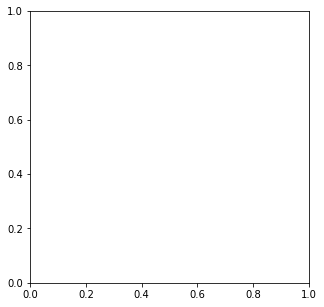

In [70]:
conc_comparison_fig, ax = plt.subplots(nrows=1, ncols=1,
                                       figsize=(5, 5))

plot_comparison(
    x=conc_df["Concentration (M)"], y=conc_solution,
    compare="concentrations",
    observable=[mid for mid in conc_df.index], ax=ax,
    legend="right outside", plot_function="loglog", 
    xlim=(1e-6,0.02), ylim=(1e-6,1e-1),
    xy_line=True,
    xy_legend="best", xlabel="Initial [mol/L]", ylabel="Adjusted [mol/L]")

conc_comparison_fig.tight_layout()
update_model_with_concentration_solution(
    liver, conc_solution, concentrations=True, inplace=True);

In [ ]:
# Keq_data = pd.read_csv("./data/analysis_data/equilibrium_constants.csv", index_col=0)

# Keq_data_comparison_fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
# plot_comparison(
#     x=Keq_data["Initial"], y=Keq_data["Adjusted"], ax=ax,
#     title="Equilibrium Constants comparison",
#     legend="right outside", plot_function="loglog",
#     xlim=(1e-5, 1e5), ylim=(1e-5, 1e5), 
#     xy_line=True,
#     xy_legend="best", xlabel="Initial", ylabel="Adjusted")

# Keq_data_comparison_fig.tight_layout()

In [66]:
Boundary= [
    "ATPM",
    
#     'EX_nad_c',
    # "EX_lac__L_c"
]
for x in Boundary:
    a=liver.reactions.get_by_id(x)
    a.kf=1e6

In [67]:
 liver.steady_state_fluxes.items()

dict_items([(<MassReaction PGI at 0x2394eeda3d0>, -250.0), (<MassReaction FBP at 0x2394ed8de80>, 250.0), (<MassReaction FBA at 0x2394eeda730>, -250.0), (<MassReaction TPI at 0x2394ebeb520>, -250.0), (<MassReaction GAPD at 0x2394eedab50>, -500.0), (<MassReaction PGK at 0x2394eeda3a0>, 500.0), (<MassReaction PGM at 0x2394eedafa0>, 500.0), (<MassReaction ENO at 0x2394eedad90>, -500.0), (<MassReaction PEPCKm at 0x2394eedad30>, 500.0), (<MassReaction PCm at 0x2394eee22e0>, 500.0), (<MassReaction LDH_L at 0x2394eee2700>, 500.0), (<MassReaction PYRt2m at 0x2394eee24f0>, 500.0), (<MassReaction ADK1 at 0x2394eee2b20>, -250.0), (<MassReaction ATPM at 0x2394eee2d00>, 0.0), (<MassReaction NADHM at 0x2394eee2910>, 0.0), (<MassReaction PEPtm at 0x2394eee2fa0>, 500.0), (<MassReaction G6PP at 0x2394eee2f10>, 250.0), (<MassReaction EX_glc__D_c at 0x2394eee8520>, 250.0), (<MassReaction EX_h2o_c at 0x2394eee8730>, -1000.0), (<MassReaction EX_h_c at 0x2394eee89a0>, -500.0), (<MassReaction EX_pi_c at 0x239

In [68]:
liver.calculate_PERCs(fluxes={
                r: v for r, v in liver.steady_state_fluxes.items()
                if not (r.boundary  
#                         or r== liver.reactions.GLCter or r== glycogenolysis.reactions.PIter
#                                or r== glycogenolysis.reactions.G6Pter or r== glycogenolysis.reactions.PIt or 
#                                 r== glycogenolysis.reactions.PYRt2m or 
#                                 r== glycogenolysis.reactions.L_LACt2r or 
#                                 r== glycogenolysis.reactions.PYRt2 or 
#                                 r== glycogenolysis.reactions.PEPtm or r== glycogenolysis.reactions.GLCt1 
#                                 or r== glycogenolysis.reactions.Ht
                       )
},
                      update_reactions=True)
print(percs)                      

print("Forward Rate Constants\n----------------------")
for reaction in liver.reactions:
    print("{0}: {1:.6f}".format(reaction.kf_str, reaction.kf))

mass\core\mass_model.py:1742 UserWarning: Cannot calculate the PERC for reaction 'FBA' missing values for ['g3p_c'].
mass\core\mass_model.py:1742 UserWarning: Cannot calculate the PERC for reaction 'TPI' missing values for ['g3p_c'].
mass\core\mass_model.py:1742 UserWarning: Cannot calculate the PERC for reaction 'GAPD' missing values for ['g3p_c', '13dpg_c'].
mass\core\mass_model.py:1742 UserWarning: Cannot calculate the PERC for reaction 'PGK' missing values for ['13dpg_c'].


ValueError: Must be a non-negative number

In [69]:
#Function to add underscore in front of metabolite identifiers which start with a number
## fix this only after getting Keq from equlibrator because bigg doesn't have _13dpg for example
def prefix_number_id(id_str):
    """Prefix identifiers that start with numbers."""
    if re.match(r"^\d", id_str):
        id_str = "_" + id_str
    return id_str

In [ ]:
#Loop to edit the names using "prefix_number_id" function defined earlier
for metabolite in liver.metabolites:
    new_met_id = prefix_number_id(metabolite.id)
    metabolite.id = new_met_id
liver.repair()

In [ ]:
qcqa_model(liver, parameters=True, concentrations=True,
           fluxes=True, superfluous=True, elemental=True)

In [ ]:
# Setup simulation object
simG=Simulation(liver, verbose=True)
# Simulate from 0 to 1000 with 10001 points in the output
conc_sol, flux_sol = simG.simulate(liver, time=(0, 1e8))
# Quickly render and display time profiles
conc_sol.view_time_profile()

In [ ]:
#function to set x label and y label
def set_x_label(xlabel):
    if xlabel==None:
        xlabel="Time"
    else:
        xlabel=xlabel
    return xlabel
        
def set_y_label(ylabel):        
    if ylabel==None:
        ylabel="Concentrations"
    else:
        ylabel=ylabel
    return ylabel


In [ ]:
#function to make plot typelinear log
def set_plot_type(plot_type):
    if plot_type == None:
        x_plot_type = 'log'
        y_plot_type = 'log'
    elif plot_type == "logx":
        x_plot_type = 'log'
        y_plot_type = 'linear'
    elif plot_type == "logy":
        x_plot_type = 'linear'
        y_plot_type = 'log'
    elif plot_type == "linear":
        x_plot_type = 'linear'
        y_plot_type = 'linear'
    elif plot_type == "logxlogy":
        x_plot_type = 'log'
        y_plot_type = 'log'
    return x_plot_type,y_plot_type


In [ ]:
def view_all_conc_sol(conc_sol,
#                       dynamic=True
                      xlim=None,ylim=None,plot_type=None,xlabel=None,ylabel=None,width=None,height=None):
    """Generate an interactable time profile which can zoom into the plot with interactive tooltip"""
    #Shift click to click multiple
    
    data=conc_sol.to_frame()
    data = data.reset_index().melt('Time', var_name='Metabolites', value_name='Concentrations')
    
    # Setting X limit and Y limit
    def set_ylim(ylim):
        if ylim == None:
            conc=data['Concentrations']
            ylim_max=max(conc)
            ylim=[1e-5,ylim_max]
        else:
            ylim=ylim
        return ylim
    
    def set_xlim(xlim):
        if xlim == None:
            xlim_max=data['Time'].iloc[-1]
            xlim=[1e-5,xlim_max]

        else:
            xlim=xlim
        return xlim
    xlim=set_xlim(xlim)
    ylim=set_ylim(ylim)
        
       
    # Setting type of plot
    x_plot_type=set_plot_type(plot_type)[0]
    y_plot_type=set_plot_type(plot_type)[1]
        
    # Setting x label and y label
    xlabel=set_x_label(xlabel)
    ylabel=set_y_label(ylabel)
    # Setting width and height
    if width==None:
        width=500
    else:
        width=width
        
    if height==None:
        height=300
    else:
        height=height
    
    alt.data_transformers.disable_max_rows()
    selection = alt.selection_multi(fields=['Metabolites'])
    color = alt.condition(selection,
                          alt.Color('Metabolites:N', legend=None),
                          alt.value('lightgray'))

    line = alt.Chart(data).mark_line(clip=True).encode(alt.X('Time:Q',
                                                             title=xlabel,
                                                             scale=alt.Scale(type = x_plot_type,
                                                                             padding = 10,
                                                                             domain = xlim,
#                   zero=True,
                              ),
              axis=alt.Axis(tickCount=5)),
        alt.Y('Concentrations:Q',
              title=ylabel,
              scale=alt.Scale(type=y_plot_type,
                              padding = 10,
                              domain = ylim,
#                   zero=True, 
                             ),
               axis=alt.Axis(grid=False,
                             tickCount=5)),
        color=color,
        tooltip= ["Metabolites"]+["Time"]+["Concentrations"]
    ).properties(width=width, height=height).interactive()

    
    
#         if dynamic == False:
#             A = alt.layer(line)
#         else:
    legend = alt.Chart(data).mark_point().encode(
        y=alt.Y('Metabolites:N', axis=alt.Axis(orient='right')),
        color=color
    ).add_selection(
        selection
    )
    A= line | legend
    return A

In [ ]:
view_all_conc_sol(conc_sol,plot_type='logxlogy')